In [1]:
# Starts the autoreload extension, which allows editing the .py files with the notebook running and automatically imports the latest changes

%load_ext autoreload
%autoreload 2

import trim_duplicates, model, network, gradcam, plots
from dataset import Dataset
import haiku as hk
import jax.numpy as jnp
import numpy as np
import jax
import sklearn
import wandb

assert jax.local_device_count() >= 8

NUM_CLASSES = 4
SEED = 12
BATCH_SIZE = 128

def basemodel_process(x): return x

In [2]:
rng = jax.random.PRNGKey(SEED)
dataset_mendeley = Dataset.load("mendeley", rng=rng)
dataset_tawsifur = Dataset.load("tawsifur", rng=rng)
print("Loaded mendeley", dataset_mendeley.classnames)
print("Loaded tawsifur", dataset_tawsifur.classnames)

Loaded mendeley ['Normal', 'Viral pneumonia', 'COVID-19', 'Pneumonia bacterial']
Loaded tawsifur ['Normal', 'Viral pneumonia', 'COVID-19', 'Lung opacity']


In [3]:
net, optim = model.init_net_and_optim(dataset_mendeley.x_train, NUM_CLASSES, BATCH_SIZE)

# Gets functions for the model
net_container = network.create(net, optim, BATCH_SIZE, shape = (10, 256, 256, 3))

In [4]:
def five_fold_cross_validation(model_name, original_dataset, process_fn, seed=12, num_epochs=30, use_wandb=False):
    config = { 'dataset' : original_dataset.name,
               'random_seed' : seed,
               'batch_size' : BATCH_SIZE,
               'resolution' : 256 }

    group = model_name + '_CV'

    for i in range(5):
        job_type = 'train_and_eval'
        # RUN 1: Train and eval
        if use_wandb:
            run = wandb.init(project='xrays', entity='usp-covid-xrays',
                            group=group,
                            job_type=job_type,
                            name=model_name + "_CV_" + str(i),
                            reinit=True, config = config)

        cv_dataset = original_dataset.five_fold(i)

        trained = model.train_model(model_name + "_CV" + str(i),
                          net_container, process_fn,
                          cv_dataset, masks = None,
                          num_epochs = num_epochs,
                          wandb_run = run if use_wandb else None)

        if use_wandb:
            run.finish()

        # RUN 2: Remove duplicates
        if use_wandb:
            run2 = wandb.init(project='xrays', entity='usp-covid-xrays',
                            group=group,
                            job_type='duplicate_removal',
                            name='duprem_' + model_name + "_CV_" + str(i),
                            reinit=True, config = config)
        
        sims = trim_duplicates.compute_similarities(cv_dataset, net_container, trained, pixel_space=False)
        cv_dataset_curated = trim_duplicates.remove_duplicates("", cv_dataset, sims,
                                        wandb_run=run2 if use_wandb else None)
        
        pix_sims = trim_duplicates.compute_similarities(cv_dataset, net_container, trained, pixel_space=True)
        trim_duplicates.remove_duplicates("pix_", cv_dataset, pix_sims,
                                          wandb_run=run2 if use_wandb else None)

        if use_wandb:
            run2.finish()

        # RUN 3: Re-train and re-eval
        if use_wandb:
            run3 = wandb.init(project='xrays', entity='usp-covid-xrays',
                            group=group,
                            job_type=job_type + '_nodups',
                            name='nodups_' + model_name + "_CV_" + str(i),
                            reinit=True, config = config)

        model.train_model('nodups_' + model_name + "_CV" + str(i),
                          net_container, process_fn,
                          cv_dataset_curated, masks = None,
                          num_epochs = num_epochs,
                          wandb_run = run3 if use_wandb else None)

        if use_wandb:
            run3.finish()

Model loaded from models/base_mendeley_CV0.pickle
Calculating embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████| 71/71 [00:48<00:00,  1.46it/s]


Computing cosine similarities...


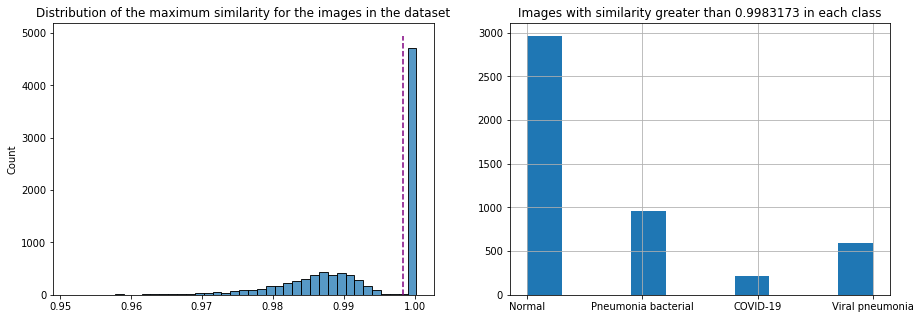

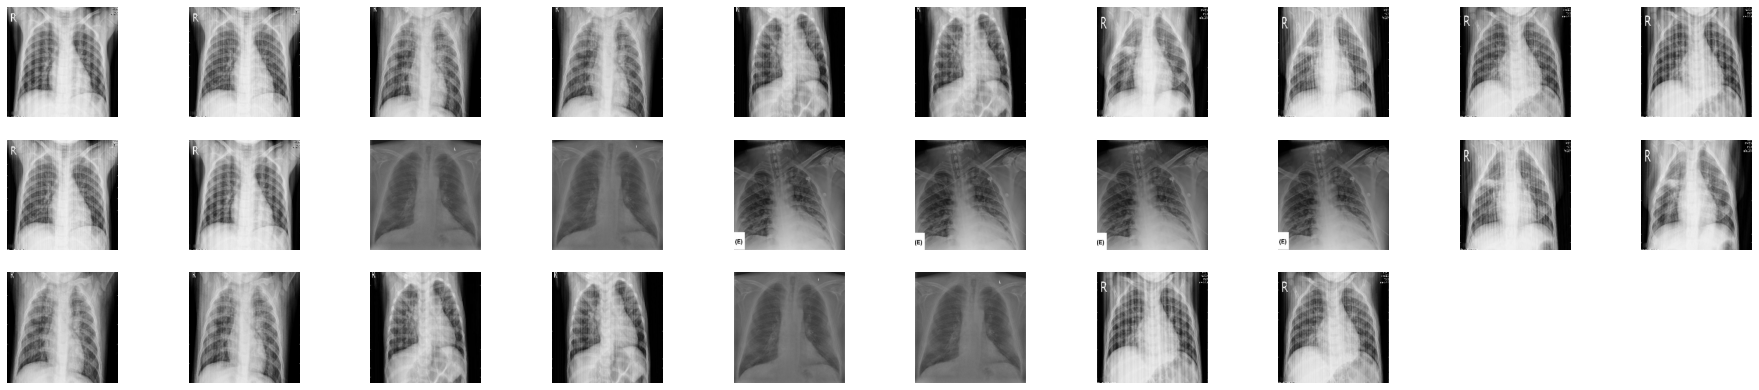

100%|██████████| 9208/9208 [01:16<00:00, 121.07it/s]


Unique images: 6627
Removed images: 2581
Duplicates found in test set: 968
Duplicates found in train set: 4120
Leaked examples from the test set: 829
Calculating embeddings...
Computing cosine similarities...


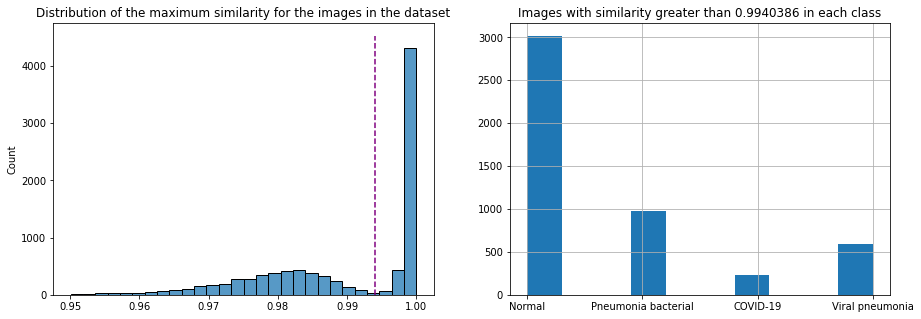

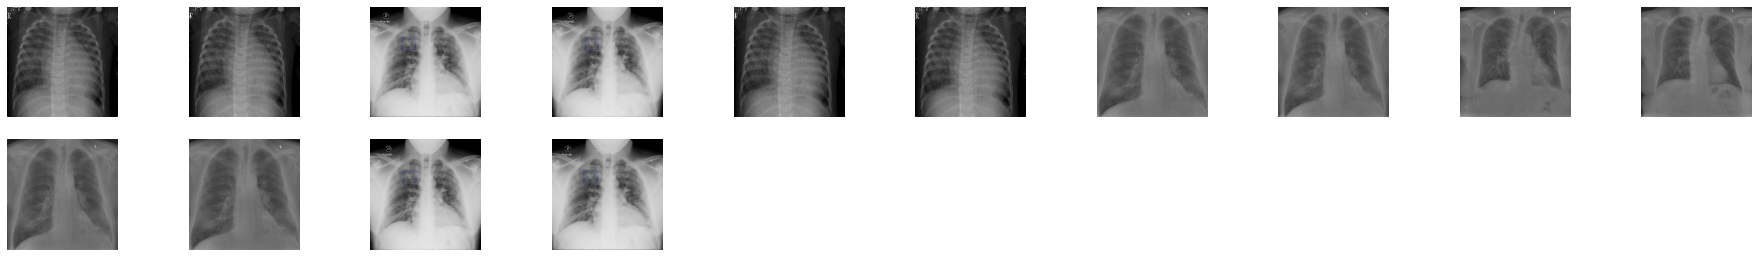

100%|██████████| 9208/9208 [01:14<00:00, 124.06it/s]


Unique images: 6580
Removed images: 2628
Duplicates found in test set: 976
Duplicates found in train set: 3853
Leaked examples from the test set: 841
Model loaded from models/nodups_base_mendeley_CV0.pickle
Model loaded from models/base_mendeley_CV1.pickle
Calculating embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████| 71/71 [00:40<00:00,  1.75it/s]


Computing cosine similarities...


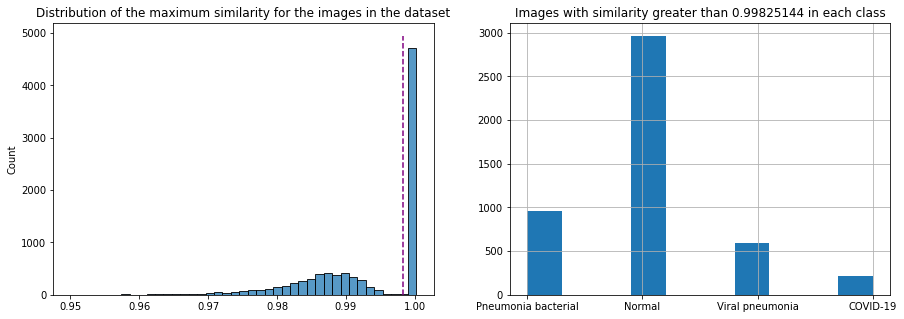

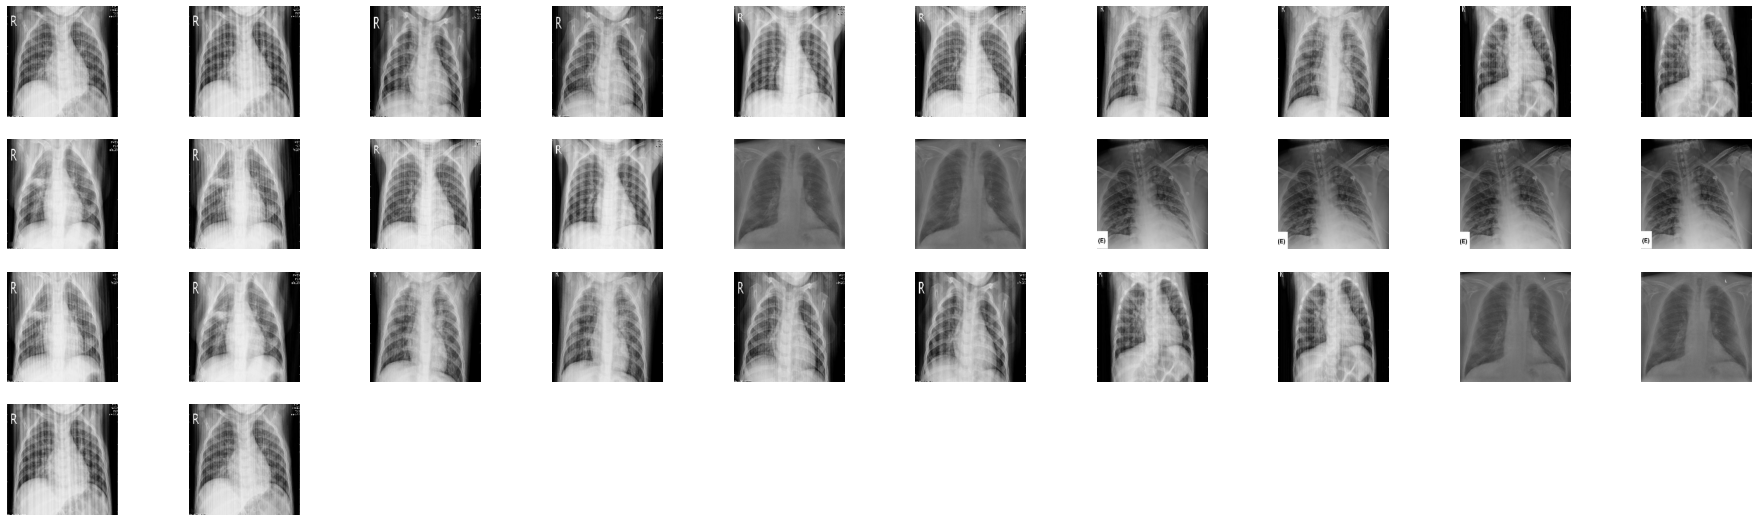

100%|██████████| 9208/9208 [01:10<00:00, 130.43it/s]


Unique images: 6626
Removed images: 2582
Duplicates found in test set: 979
Duplicates found in train set: 4111
Leaked examples from the test set: 828
Calculating embeddings...
Computing cosine similarities...


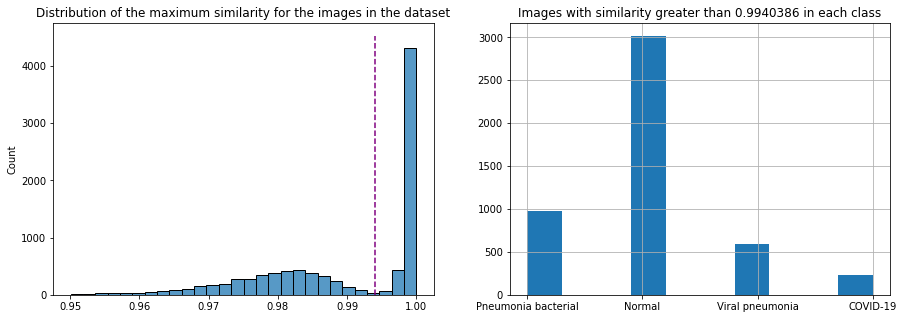

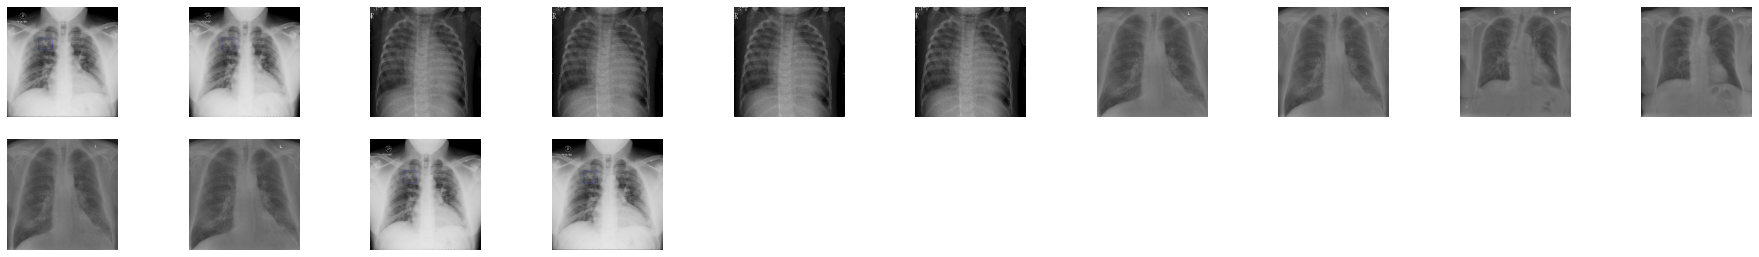

100%|██████████| 9208/9208 [01:06<00:00, 139.30it/s]


Unique images: 6580
Removed images: 2628
Duplicates found in test set: 989
Duplicates found in train set: 3840
Leaked examples from the test set: 840


  3%|█▋                                                             | 1/38 [00:29<17:58, 29.15s/it, loss=1.39, acc=0.31]


KeyboardInterrupt: 

In [7]:
assert jax.local_device_count() >= 8

five_fold_cross_validation("base_mendeley", dataset_mendeley, basemodel_process, num_epochs=30, use_wandb=True)
five_fold_cross_validation("base_tawsifur", dataset_tawsifur, basemodel_process, num_epochs=30, use_wandb=True)

In [ ]:
basemodel_tawsifur = model.train_model(model_name + "CV" + str(i), net_container, process_fn, cv_dataset)
sims = trim_duplicates.compute_similarities(dataset_tawsifur, net_container, basemodel_tawsifur)

In [ ]:
thresh = 0.998
max_sims = sims.max(axis=1) - thresh
y_classes = dataset_tawsifur.y_all[:sims.shape[0]].argmax(1)
max_sims_index = sims.argmax(axis=1)
mask = (max_sims >= 0) & (max_sims <= 0.0005)
indices = np.where(mask)[0]
plots.compare_images(dataset_tawsifur.x_all[indices], dataset_tawsifur.x_all[max_sims_index[indices]], rows=10)
#trim_duplicates.plot_similarities(dataset_tawsifur, sims, threshold=0.99)

In [ ]:
trim_duplicates.plot_similarities(dataset_tawsifur, sims, threshold=thresh)
dataset_tawsifur_curated = trim_duplicates.remove_duplicates(dataset_tawsifur, sims, threshold=thresh)

In [ ]:
print(dataset_tawsifur_curated.x_train.shape, dataset_tawsifur.x_train.shape)

In [ ]:
basemodel_tawsifur_curated = model.train_model("basemodel_tawsifur_curated", net_container, basemodel_process, dataset_tawsifur_curated)
y_pred_tawsifur_curated = net_container.predict(basemodel_tawsifur_curated.params, basemodel_tawsifur_curated.state, dataset_tawsifur_curated.x_test)
plots.confusion_matrix(dataset_tawsifur_curated, y_pred_tawsifur_curated, "Tawsifur - Curated")

# Transfer learning test

In [ ]:
rng = jax.random.PRNGKey(SEED)
dataset_mendeley = Dataset.load("mendeley", rng=rng)

net, optim = model.init_net_and_optim(dataset_mendeley.x_train, NUM_CLASSES, BATCH_SIZE)

# Gets functions for the model
net_container = network.create(net, optim, BATCH_SIZE, shape = (10, 256, 256, 3))

In [ ]:
# Test of tawsifur on mendeley

basemodel_tawsifur = model.train_model("basemodel_tawsifurCV0", net_container, basemodel_process, dataset_mendeley)
y_test_pred = net_container.predict(basemodel_tawsifur.params, basemodel_tawsifur.state, dataset_mendeley.x_test)
matrix = sklearn.metrics.confusion_matrix(
        dataset_mendeley.y_test[0:y_test_pred.shape[0],].argmax(1),
        y_test_pred.argmax(1), normalize = 'true'
    )
plots.heatmatrix(matrix, "Transfer learning from tawsifur to mendeley")